# Sparkify Project Workspace

This is the final project of my Udacity Nanodegree as Data Scientist. Goal of the project is to predict user churn of an online music streaming service using machine learning algorithms. 

Basis of the project is 12 GB dataset containing all information about user interactions with the online streaming service. The data is stored in a AWS Simple Storage Service (S3) bucket in JSON format.
Datasets of such a large scale are challenging to process on a single computer and are therefore referred to as big data. 

I will use Apache Spark to work with the full dataset. Apache Spark is a popular tool for large scale data processing. It allows to efficiently spread data and computations across a network of distributed computers, called clusters. Each cluster has nodes (computers) that do the computations in parallel.
This workspace contains a tiny subset (128MB) of the full dataset available. I will explore the smaller subset with descriptive statistics using Spark before creating a Spark machine learning model based on the full dataset. The full dataset will be processed in Amazon Web Services (AWS) with an Elastic Map Reduce (EMR) cluster of 3 m5.xlarge machines. 

The project is structured following CRISP-DM, the Cross Industry Process for Data Mining. These are the steps:

- [1. Business Understanding](#BU)
- [2. Data Understanding](#DU)
- [3. Prepare Data](#prepare)
- [4. Data Modeling](#modeling)
- [5. Evaluate the Results](#evaluate)
- [6. Deploy](#deploy)

### Load libraries, create Spark session and import data 

In [1]:
# import libraries for Spark Session
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# import libraries for sql actions
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, countDistinct, datediff
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

# other non-spark libraries

import datetime
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Spark ML libraries

from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# view information about spark configuration
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1610014790125'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '64201'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '192.168.1.75')]

In [4]:
# define path and load data
path = 'data/mini_sparkify_event_data.json'
user_log = spark.read.json(path)

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.

<a id='BU'></a>
## 1. Business Understanding

Sparkify is a (fictional) music streaming service with a business case similar to Spotify. The service can be used on two levels, free tier or premium tier. Both levels of service generate revenue for Sparkify. The free tier service is financed by advertisement in between the songs, the premium tier consists of a monthly or yearly subscription fee to have an advertisement free experience. 
At any moment the user can decide to downgrade from paid/premium to free, upgrade from free to paid/premium or to cancel from the service completely.
    
Customer churn is when a customer unsubscribes from a service, ceases to purchase a product or stops engaging with a service [[1](https://www.retentionscience.com/blog/why-measuring-your-customer-churn-rate-increases-revenue/)]. In the case of the music streaming service of this project I will define churn as `Cancellation Confirmation` events, which happen for both paid and free tier users.

Usually it is more expensive for a business to acquire new customers than retaining existing customers. Statistics vary from industry to industry, but research indicates that it may cost up to 5 times more to acquire a new customer than to keep an existing one [[2](https://www.forbes.com/sites/jiawertz/2018/09/12/dont-spend-5-times-more-attracting-new-customers-nurture-the-existing-ones/?sh=36d7a6225a8e)].

To prevent churn candidates special discounts or other costly measures are offered to customers. These measures usually lower the revenue. The goal is to identify users who are about to churn ahead of time and only target them with marketing campaigns. 
Churn prediction is an important classification use case for streaming services such as Netflix, Spotify or Apple Music. Companies that can predict customers who are about to churn ahead of time can implement a more effective customer retention strategy.

<a id='DU'></a>
## 2. Data Understanding

Let's look into the available columns of the data subset (128MB) and their meaning:

In [5]:
# check schema of object
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# look at first two rows to get an idea
user_log.head(n=2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [7]:
# check length of dataset
print('The dataset contains {} rows'.format(user_log.count()))

The dataset contains 286500 rows


#### Column 'artist'

In [8]:
# count unique artists in dataset
unique_artists = user_log.select('artist').dropDuplicates().count()

print('There are {} unique artists in the dataset.'.format(unique_artists))

There are 17656 unique artists in the dataset.


In [9]:
# list artists by occurance
user_log.select(['artist', 'song']).groupby('artist').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



Null is the most common value in the dataset for the column artist. I will have to investigate if these rows are valid or if they should be dropped.

#### Column 'auth'

In [10]:
# list unique values in authentication column by occurances
user_log.select(['auth', 'userId']).groupby('auth').count().orderBy('count', ascending=False).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [11]:
# look into sample rows of authentication status guest
user_log.filter('auth = "Guest"').show(n=2)

+------+-----+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist| auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+-----+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Guest|     null|  null|            0|    null|  null| free|    null|   GET|Error|        null|      151|null|   404|1540841775000|     null|      |
|  null|Guest|     null|  null|            1|    null|  null| free|    null|   GET| Home|        null|      151|null|   200|1540841817000|     null|      |
+------+-----+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
only showing top 2 rows



It is possible to interact with Sparkify as a guest. These rows can be dropped, as it is not possible to assign the user interactions of guests to a userId.

In [12]:
# look into sample rows of authentication status guest
user_log.filter('auth = "Cancelled"').show(n=2)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
+----

The rows with authentication cancelled seem to be valid.

#### Columns 'gender' and 'userId'

In [13]:
# show unique possible values of column 'gender' and occurances
user_log.select(['gender', 'userId']).groupby('gender').count().orderBy('count', ascending=False).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



To see how many users are of which gender we have to look at unique userIds. Then we can answer if the dataset is balanced regarding gender.

In [14]:
# check if dataset is balanced regarding gender of userId's

unique_users = user_log.select('userId').dropDuplicates().count()

male_users = user_log.select('userId').dropDuplicates().filter('gender = "M"').count()
female_users = user_log.select('userId').dropDuplicates().filter('gender = "F"').count()
unknown_gender_users = user_log.select('userId').dropDuplicates().filter('gender = "null"').count()

print('There are {} unique users by userId in the dataset. \nOf those users {} are male and {} are \
female users. \nThere are {} userId\'s where the gender is not known'.format(
unique_users, male_users, female_users, unknown_gender_users))

There are 226 unique users by userId in the dataset. 
Of those users 121 are male and 104 are female users. 
There are 0 userId's where the gender is not known


The dataset is more or less balanced regarding gender of users. The null values in gender are not present when filtering for unique userId's.

#### Columns 'itemInSession', 'sessionId', 'song', 'ts'  and 'length'

In [15]:
# look at behaviour of values in itemInSession for one user as example
user_log.select(['itemInSession', 'userId', 'sessionId', 'ts', 'page', 'song', 
                 'firstName', 'length']).filter('userId = "18"').show()

+-------------+------+---------+-------------+--------+--------------------+---------+---------+
|itemInSession|userId|sessionId|           ts|    page|                song|firstName|   length|
+-------------+------+---------+-------------+--------+--------------------+---------+---------+
|            0|    18|      242|1538499917000|    Home|                null|   Adriel|     null|
|            1|    18|      242|1538499933000|NextSong|A Beggar On A Bea...|   Adriel|275.12118|
|            2|    18|      242|1538500208000|NextSong|...slowdance On T...|   Adriel|268.32934|
|            3|    18|      242|1538500476000|NextSong|       St. Apollonia|   Adriel|178.72934|
|            4|    18|      242|1538500654000|NextSong|      Drunk Stripper|   Adriel|188.76036|
|            5|    18|      242|1538500842000|NextSong|In League With Satan|   Adriel|167.91465|
|            6|    18|      242|1538500856000|Settings|                null|   Adriel|     null|
|            7|    18|      24

The values in column itemInSession count the interactions which happend for one user during the same sessionId. The value in column length describes the duration of time the song was played and therefore is null for all  page events other than NextSong. Ts stands for timestamp.

#### Column 'level'

In [16]:
# show unique possible values of column 'level'
user_log.select(['level', 'userId']).dropDuplicates().groupby('level').count().orderBy('count', ascending=False).show()

+-----+-----+
|level|count|
+-----+-----+
| free|  196|
| paid|  166|
+-----+-----+



There are 196 unique userIds of free tier and 166 of paid tier users.

#### Column 'location'

In [17]:
# show unique possible values of column 'location'
user_log.select('location').dropDuplicates().sort('location').show(n=8, truncate=False)

+---------------------------------+
|location                         |
+---------------------------------+
|null                             |
|Albany, OR                       |
|Albany-Schenectady-Troy, NY      |
|Alexandria, LA                   |
|Allentown-Bethlehem-Easton, PA-NJ|
|Anchorage, AK                    |
|Atlanta-Sandy Springs-Roswell, GA|
|Atlantic City-Hammonton, NJ      |
+---------------------------------+
only showing top 8 rows



In [18]:
# check the highest count of unique locations per userId
user_log.select(['userId', 'location']).groupby(
    'userId').agg(countDistinct('location')).orderBy('count(location)', ascending=False).show(n=3)

+------+---------------+
|userId|count(location)|
+------+---------------+
|   138|              1|
|300017|              1|
|100021|              1|
+------+---------------+
only showing top 3 rows



In the dataset users always access the streaming service from the same location.

#### Column 'method'

In [19]:
# show unique possible values of column 'method'
user_log.select(['method', 'userId']).groupby('method').count().orderBy('count', ascending=False).show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



#### Column 'page'

In [71]:
# show unique possible values of column 'page'
user_log.select(['page', 'userId']).groupby('page').count().orderBy('count', ascending=False).show(n=30)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



The most called page is NextSong which is the main function of the streaming service. The Home page is the page the user enters when starting a streaming session. 

#### Column 'registration'

In [21]:
# look at behaviour of values in itemInSession for one user as example
user_log.select(['userId', 'registration']).groupby(
    'userId').agg(countDistinct('registration')).orderBy('count(registration)', ascending=False).show(n=3)

+------+-------------------+
|userId|count(registration)|
+------+-------------------+
|100021|                  1|
|    69|                  1|
|    29|                  1|
+------+-------------------+
only showing top 3 rows



It seems like every userId has exactly one registration.

#### Column 'userAgent'

In [22]:
# show unique possible values of column 'userAgent'
user_log.select('userAgent').dropDuplicates().show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


The column user agent describes the software used to access the streaming service. Examples are Mac OS X with Safari, Windows or Ubuntu.

### Clean Dataset
Clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [23]:
# count rows 
user_log.count()

286500

In [24]:
# drop any record with NANs in user ID OR session ID and save to new object
user_log_valid = user_log.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [25]:
# check amount of  records
user_log_valid.count()

286500

It turns out there are no missing values in the userID or session columns.

In [26]:
# show unique user IDs
user_log.select('userId').dropDuplicates().sort('userId').show(n=8)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
+------+
only showing top 8 rows



But there are userID values that are empty strings.

In [27]:
# drop empty user IDs
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')

In [28]:
# check if now less than 286500 records
user_log_valid.count()

278154

In [29]:
# check if guest entries are dropped all
user_log_valid.select(['auth', 'userId']).groupby('auth').count().orderBy('count', ascending=False).show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



In [30]:
# calculate amount of users dropped
amount_users_dropped = user_log.count() - user_log_valid.count()
amount_logged_out = user_log.select('auth').filter('auth = "Logged Out"').count()
amount_guest = user_log.select('auth').filter('auth = "Guest"').count()
amount_rows = user_log_valid.count()

print('{} Rows without userId were dropped. This were the users with authentification status "Logged Out" ({}) \
and "Guest" ({}). Resulting into {} rows in the cleaned dataset.'.format(
    amount_users_dropped, amount_logged_out, amount_guest, amount_rows))

8346 Rows without userId were dropped. This were the users with authentification status "Logged Out" (8249) and "Guest" (97). Resulting into 278154 rows in the cleaned dataset.


<a id='prepare'></a>
## 3. Prepare Data

### 3.1 Define Churn

Create a column `Churn` to use as the label for model. Using the `Cancellation Confirmation` events to define  churn, which happen for both paid and free users. Additionally look into the `Downgrade` events.

In [31]:
# show records where downgrade was submitted (churn)
user_log_valid.filter("page = 'Cancellation Confirmation'").show(n=3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [32]:
# Find users who had event 'Cancellation Confirmation'
user_log_valid.select('userID').where(user_log.page == 'Cancellation Confirmation').show(n=8)

+------+
|userID|
+------+
|    18|
|    32|
|   125|
|   105|
|    17|
|   143|
|   101|
|   129|
+------+
only showing top 8 rows



In [33]:
# inspect example with event 'Cancellation Confirmation' (without most common event NextSong event)
user_log_valid.select(['userId', 'firstname', 'page', 'level', 'song', 'sessionId']).where(
    (user_log_valid.userId == '101') & (user_log_valid.page != 'NextSong')).collect()


[Row(userId='101', firstname='Alex', page='Home', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Help', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Add Friend', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Home', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Thumbs Up', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Roll Advert', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Thumbs Up', level='free', song=None, sessionId=100),
 Row(userId='101', firstname='Alex', page='Rol

In [34]:
# user defined function to flag the events page=submit 'Cancellation Confirmation' with extra column
flag_cancellation_event = udf(
    lambda cancellation_event: 1 if cancellation_event == 'Cancellation Confirmation' else 0, IntegerType())

In [35]:
# create extra column 'Cancellation Confirmation'
user_log_valid = user_log_valid.withColumn('cancellation_event', flag_cancellation_event('page'))

In [36]:
# check if column 'cancellation_event' is filled correctly
user_log_valid.select(['page', 'level', 'cancellation_event']).where(
    (user_log_valid.userId == '101') & (user_log_valid.sessionId == '842')).collect()

[Row(page='Home', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='Add Friend', level='paid', cancellation_event=0),
 Row(page='Add Friend', level='paid', cancellation_event=0),
 Row(page='Add Friend', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event=0),
 Row(page='NextSong', level='paid', cancellation_event

The new column 'cancellation_event' was created to mark the exact event of cancellation confirmation. As the goal of this project is to predict users who eventually churn, it is important to find the features which describe best the differences between users who churn and those who not.
There is another column necessary to compare all user intereactions made by users who eventually churned to users who did not churn. The values of the new column 'churned users' are 1 if the user will eventually churn and 0 if not.

In [37]:
# create column with churned users = true
churned_users = user_log_valid.select('userId').filter(user_log.page == 'Cancellation Confirmation').dropDuplicates().collect()

userid_churn = []
for i in churned_users:
    userid_churn.append(i[0])
    
user_log_valid = user_log_valid.withColumn('churned',user_log_valid['userId'].isin(userid_churn))

In [38]:
# check if column 'cancellation_event' is filled correctly
user_log_valid.select(['page', 'level', 'cancellation_event', 'churned']).where(
    (user_log_valid.userId == '101') & (user_log_valid.sessionId == '842')).collect()

[Row(page='Home', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_event=0, churned=True),
 Row(page='Add Friend', level='paid', cancellation_event=0, churned=True),
 Row(page='Add Friend', level='paid', cancellation_event=0, churned=True),
 Row(page='Add Friend', level='paid', cancellation_event=0, churned=True),
 Row(page='NextSong', level='paid', cancellation_

### 3.2 Exploratory Data Analysis

Goal now is to observe the behavior for users who stayed vs users who churned with an exploratory data analysis. First step will be to explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [39]:
# check if dataset is balanced regarding churned users

In [40]:
users = user_log_valid.select('userId').dropDuplicates().count()
churned_users = user_log_valid.filter('churned = True').select('userId').dropDuplicates().count()
stayed_users = user_log_valid.filter('churned = False').select('userId').dropDuplicates().count()

print('Of total {} users, {} users stayed with the streaming service during the observed timer and  \
{} users eventually churned ({}% users churned).'.format(users, stayed_users, churned_users, 
                                                         churned_users/users*100))

Of total 225 users, 173 users stayed with the streaming service during the observed timer and  52 users eventually churned (23.11111111111111% users churned).


There is a imbalance in the dataset regarding the amount of users who churned versus those who stayed. Next step is to check how this imbalance in amount of users scales on the amount of interactions.

In [41]:
user_interactions = user_log_valid.count()
churned_users_interactions = user_log_valid.filter('churned = True').count()
stayed_users_interactions = user_log_valid.filter('churned = False').count()

print('Of total {} user interactions, {} user interactions were recorderd of useres who stayed with the \
streaming service during the observed timer and {} user interactions were recorded of users who eventually \
churned ({}% users churned).'.format(user_interactions, churned_users_interactions, stayed_users_interactions,
                                    churned_users_interactions/user_interactions*100))

Of total 278154 user interactions, 44864 user interactions were recorderd of useres who stayed with the streaming service during the observed timer and 233290 user interactions were recorded of users who eventually churned (16.129194618808288% users churned).


The amount of data available regarding interactions to analyze the difference in behaviour for users who stayed vs users who churned is clearly imbalanced. 

There are different ways to handle imbalanced data....

[imbalanced data](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

#### Downgrade Events from paid tier to free tier

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.



xxxxxxxxxxxxxxxx

In [42]:
# show records where downgrade was submitted (churn)
user_log_valid.filter("page = 'Submit Downgrade'").show(n=3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+------------------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|cancellation_event|churned|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+------------------+-------+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|                 0|  false|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgr

In [43]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "30").collect()

user_log_valid.select(['userId', 'sessionId', "page", "level"]).where(
    (user_log_valid.page != 'NextSong') & (user_log_valid.userId == '131')).collect()


[Row(userId='131', sessionId=249, page='Add to Playlist', level='free'),
 Row(userId='131', sessionId=249, page='Help', level='free'),
 Row(userId='131', sessionId=249, page='Home', level='free'),
 Row(userId='131', sessionId=249, page='Upgrade', level='free'),
 Row(userId='131', sessionId=249, page='Submit Upgrade', level='free'),
 Row(userId='131', sessionId=249, page='Home', level='paid'),
 Row(userId='131', sessionId=249, page='Thumbs Up', level='paid'),
 Row(userId='131', sessionId=249, page='Thumbs Up', level='paid'),
 Row(userId='131', sessionId=249, page='Add to Playlist', level='paid'),
 Row(userId='131', sessionId=249, page='Downgrade', level='paid'),
 Row(userId='131', sessionId=249, page='Submit Downgrade', level='paid'),
 Row(userId='131', sessionId=249, page='Error', level='paid'),
 Row(userId='131', sessionId=249, page='Help', level='paid'),
 Row(userId='131', sessionId=249, page='Add Friend', level='paid'),
 Row(userId='131', sessionId=249, page='About', level='paid'),


In [44]:
# user defined function to flag the events page=submit downgrade with extra column
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [45]:
# create extrac column "downgraded"
user_log_valid = user_log_valid.withColumn('downgrade_event', flag_downgrade_event('page'))

In [46]:
# check if column existst
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', cancellation_event=0, churned=False, downgrade_event=0)

#### Calculating Statistics by Hour

In [47]:
# create user defined function to convert the ts column into hour format
get_hour = udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000.0). hour)

In [48]:
# create new column "hour" by applying udf get_hour
user_log_valid = user_log_valid.withColumn('hour', get_hour(user_log_valid.ts))

In [49]:
# check if hour column present in first record
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', cancellation_event=0, churned=False, downgrade_event=0, hour='2')

In [50]:
# take only amount of action "NextSong" and group it by hour of day
songs_in_hour = user_log_valid.filter(user_log_valid.page == 'NextSong').groupby(
    'hour').count().orderBy(user_log_valid.hour.cast('float'))

In [51]:
# show resulting table
songs_in_hour.show(n=24)

+----+-----+
|hour|count|
+----+-----+
|   0| 9908|
|   1| 9327|
|   2| 8895|
|   3| 8339|
|   4| 8359|
|   5| 8229|
|   6| 7979|
|   7| 8114|
|   8| 8119|
|   9| 8225|
|  10| 8359|
|  11| 8602|
|  12| 8653|
|  13| 9225|
|  14| 9479|
|  15|10047|
|  16|11036|
|  17|11381|
|  18|11568|
|  19|11346|
|  20|10940|
|  21|10893|
|  22|10823|
|  23|10262|
+----+-----+



In [52]:
# convert spark object ot pandas dataframe
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

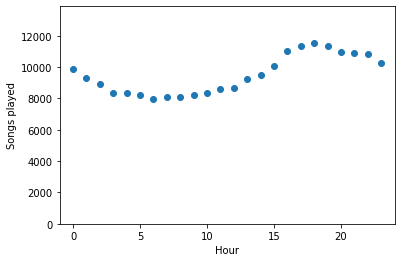

In [53]:
# plot the amount of songs played over hours of day
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd['count']))
plt.xlabel('Hour')
plt.ylabel('Songs played');

#### Total Amount of Page Events per UserId

In [102]:
# total amount of page events per userId
page_event_per_user = user_log_valid.select('page','userId', 'churned') \
    .groupby('userId', 'churned').count() \
    .withColumnRenamed('count', 'total_page_events') \

page_event_per_user.orderBy('total_page_events', ascending=False).show(n=5)

+------+-------+-----------------+
|userId|churned|total_page_events|
+------+-------+-----------------+
|    39|  false|             9632|
|    92|  false|             7230|
|   140|  false|             6880|
|300011|  false|             5732|
|   124|  false|             4825|
+------+-------+-----------------+
only showing top 5 rows



In [104]:
# mean of page events per user
page_event_per_user_pd.groupby('churned').mean()

,total_page_events
churned,
False,1348.497110
True,862.769231


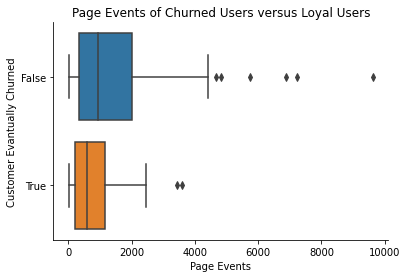

In [90]:
# convert spark object to pandas dataframe
page_event_per_user_pd = page_event_per_user.toPandas()

# Plot
ax = sns.boxplot(data=page_event_per_user_pd, y='churned', x='total_page_events', orient='h')
plt.xlabel('Page Events')
plt.ylabel('Customer Evantually Churned')
plt.title('Page Events per User Churned versus Loyal')
sns.despine(ax=ax);

Comparing users who churned with those who stayed, there is clearly a difference in mean page events per user. This difference could be an effect of that users who do not churn the service in mean use it for a longer time since registration. In the following cells will be investigated if there is a difference in page events per session as well. 

#### Page Events per SessionId per UserId

#### Number of days from registration date to last observed event

In [57]:
# number of days since registration

# for every user find registration event
min_ts = user_log_valid.select('userId', 'churned', 'ts') \
    .groupBy('userId', 'churned') \
    .agg({'ts':'min'})

# for every user find last event
max_ts = user_log_valid.select('userId', 'churned', 'ts') \
    .groupBy('userId') \
    .agg({'ts':'max'})

# for every user calculate time from registration event to last event
register_duration = min_ts.join(max_ts, on=['userId'], how='inner')

udf_convert_ts = udf(lambda timestamp: datetime.datetime.fromtimestamp(
    timestamp / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

register_duration = register_duration \
    .withColumn('registration', udf_convert_ts('min(ts)')) \
    .withColumn('last_page_event', udf_convert_ts('max(ts)')) \
    .select('userId', 'churned', 'registration', 'last_page_event') \

register_duration = register_duration \
    .withColumn('register_duration', datediff(col('last_page_event'), col('registration'))) \
    .orderBy('register_duration', ascending=False)


In [58]:
register_duration.show()

+------+-------+-------------------+-------------------+-----------------+
|userId|churned|       registration|    last_page_event|register_duration|
+------+-------+-------------------+-------------------+-----------------+
|300011|  false|2018-10-01 23:48:13|2018-12-01 01:00:11|               61|
|    30|  false|2018-10-01 02:01:57|2018-12-01 00:58:40|               61|
|    81|  false|2018-10-01 18:41:46|2018-12-01 00:56:13|               61|
|    92|  false|2018-10-01 14:41:10|2018-12-01 00:34:25|               61|
|    93|  false|2018-10-01 17:48:39|2018-12-01 00:43:25|               61|
|    39|  false|2018-10-01 08:35:48|2018-12-01 00:59:15|               61|
|   142|  false|2018-10-01 07:35:21|2018-11-30 20:32:17|               60|
|    95|  false|2018-10-01 06:21:42|2018-11-30 16:27:24|               60|
|    38|  false|2018-10-01 22:18:36|2018-11-30 20:33:21|               60|
|   131|  false|2018-10-01 10:59:15|2018-11-30 04:21:23|               60|
|200023|  false|2018-10-0

In [59]:
register_duration.groupBy('churned').mean().show()

+-------+----------------------+
|churned|avg(register_duration)|
+-------+----------------------+
|   true|                  23.5|
|  false|    46.971098265895954|
+-------+----------------------+



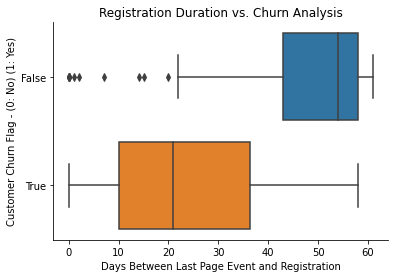

In [60]:
# convert spark object ot pandas dataframe
register_duration_pd = register_duration.toPandas()

# Plot
ax = sns.boxplot(data=register_duration_pd, y='churned', x='register_duration', orient='h')
plt.xlabel('Days Between Last Page Event and Registration')
plt.ylabel('Customer Evantually Churned')
plt.title('Registration Duration Churned Users versus Loyal Users')
sns.despine(ax=ax);

There is a significant difference in registration duration comparing churned customers with those who stayed with the service. The mean duration from registration to last interaction with the streaming service is 23.5 days for users who eventually churn and 46.97 days for users who stay with the service. Therefore the time passed since a user registered to the streaming service is feature that can be useful to predict users who are prone to churn.

#### Average amount songs played between visiting home

In [75]:
# How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

# TODO: filter out 0 sum and max sum to get more exact answer

udf_homevisit = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

songs_per_homevisit = user_log_valid.filter((user_log_valid.page == "NextSong") | (user_log_valid.page == 'Home')) \
    .select('userID', 'churned', 'page', 'ts') \
    .withColumn('homevisit', udf_homevisit(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

songs_per_homevisit = songs_per_homevisit.filter((songs_per_homevisit.page == 'NextSong')) \
    .groupBy('userID', 'churned', 'period') \
    .agg({'period':'count'}) \
    .groupBy('userID', 'churned').mean() \
    .withColumnRenamed('avg(count(period))', 'avg_songs_between_home') \
    .select('userID', 'churned', 'avg_songs_between_home')


songs_per_homevisit.groupBy('churned') \
    .agg({'avg_songs_between_home':'avg'}).show()

+-------+---------------------------+
|churned|avg(avg_songs_between_home)|
+-------+---------------------------+
|   true|           20.1673161767835|
|  false|         22.316737146091974|
+-------+---------------------------+



In [76]:
songs_per_homevisit.orderBy('avg_songs_between_home', ascending=True).show()

+------+-------+----------------------+
|userID|churned|avg_songs_between_home|
+------+-------+----------------------+
|100011|   true|                  2.75|
|   156|  false|                   3.0|
|    34|  false|     5.888888888888889|
|   135|  false|                   6.0|
|    68|  false|                  7.25|
|100003|   true|     7.285714285714286|
|    64|  false|     7.666666666666667|
|   125|   true|                   8.0|
|   122|   true|                   8.2|
|   143|   true|     9.181818181818182|
|   133|  false|    10.666666666666666|
|100005|   true|    11.846153846153847|
|100001|   true|    12.090909090909092|
|   134|  false|    12.333333333333334|
|    90|  false|    12.333333333333334|
|     5|  false|    12.384615384615385|
|100006|   true|                  13.0|
|100017|   true|                  13.0|
|   102|  false|    13.166666666666666|
|     8|  false|    13.210526315789474|
+------+-------+----------------------+
only showing top 20 rows



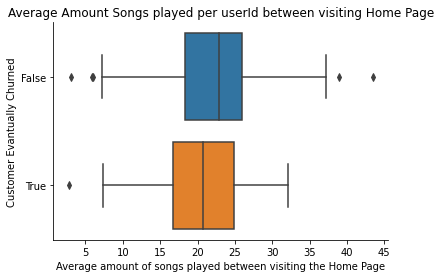

In [84]:
# convert spark object ot pandas dataframe
songs_per_homevisit_pd = songs_per_homevisit.toPandas()

# Plot
ax = sns.boxplot(data=songs_per_homevisit_pd, y='churned', x='avg_songs_between_home', orient='h')
plt.xlabel('Average amount of songs played between visiting the Home Page')
plt.ylabel('Customer Evantually Churned')
plt.title('Average Amount Songs played per userId between visiting Home Page')
sns.despine(ax=ax);

Users who evantually churned did in average play about two songs less between visiting the Home page than users who stayed with the service. Churned users played in average 20.16 songs between visiting the Home page, loyal users played in average 22.316 songs.

#### Functions for Events per UserId

In [116]:
def count_events_per_user(pyspark_df, event):
    '''
    Function to calculate amount of certain events per userId.
    
    args:
        pyspark_df - (pyspark dataframe) user_log of Sparkify
        event - (string) page event
    return:
    '''

    total_amount_events_per_userId = pyspark_df.filter((pyspark_df.page == event)) \
        .select('userId', 'churned' ,'page') \
        .groupby('userId', 'churned').count() \
        .withColumnRenamed('count', event)
    
    return total_amount_events_per_userId

In [117]:

def boxplot_events_per_user(count_pysparkdf, event):
    '''
    Function to create boxplot of pyspark dataframe created with 'count_events_per_user' function.
    
    args:
        count_pysparkdf - (pyspark dataframe) created with 'count_events_per_user'
        event - (string) page event
    
    return:
    '''
    count_df = count_pysparkdf.toPandas()
    
    ax = sns.boxplot(data=count_df, y='churned', x=event, orient='h')
    plt.xlabel('Total amount of ' + event + ' Events')
    plt.ylabel('Customer Evantually Churned')
    plt.title('Total amount of ' + event + ' Events per UserId')
    sns.despine(ax=ax);
    
    return 

#### Thumbs Up Events per UserId

+-------+-----------------+
|churned|   avg(Thumbs Up)|
+-------+-----------------+
|   true|            37.18|
|  false|62.89411764705882|
+-------+-----------------+



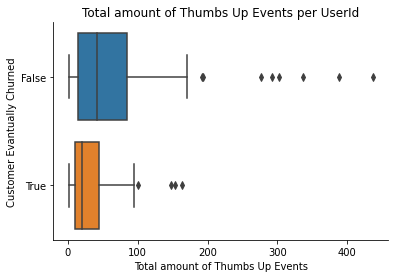

In [118]:
# calculate events per user
total_thumbs_up_per_user = count_events_per_user(user_log_valid, 'Thumbs Up')

# show table with mean of churned/stayed
total_thumbs_up_per_user.groupBy('churned').mean().show()

# create plot 
boxplot_events_per_user(total_thumbs_up_per_user, 'Thumbs Up')

Users who eventually churn give in average 37.18 Thumbs Up during usage of the service, users who stay with the service 62.98. This difference in mean is also result of a few outliers among useres who stay with the service. It would be interesting to know if the amount of thumbs up events changes shortly before churning.

#### Help Events per UserId

+-------+-----------------+
|churned|        avg(Help)|
+-------+-----------------+
|   true|5.558139534883721|
|  false|8.154362416107382|
+-------+-----------------+



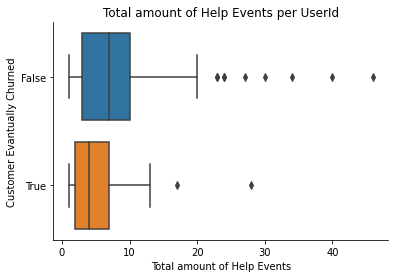

In [121]:
# calculate events per user
total_thumbs_up_per_user = count_events_per_user(user_log_valid, 'Help')

# show table with mean of churned/stayed
total_thumbs_up_per_user.groupBy('churned').mean().show()

# create plot 
boxplot_events_per_user(total_thumbs_up_per_user, 'Help')

In [92]:
# check amount of page events for churned users over time --> # mean page events over days/weeks before churn

In [70]:
# songs played in last x sessionId

In [62]:
# NextSong event per session

# page events per user per sessionId
# page events per user per hour
# Cancellation and cancellation submitting events
# Free vs paid accounts when churned
# Amount friends
# Songs in playlist 
# Thumbs down in total or last week before churn
# Help site opened total or week before churn or per sessionID
# Settings used 
# Downgrade? Upgrade? Per song
# Time spent listening to songs total or per day
# Activity (actions per day, active days per total days)
# Mean length od songs played



#### Roll advert events among free tier users in total or per time unit or session

This feature has some problematic properties. Roll adverts events can only occur to free tier users. Therefore all information retrieved from differences in occurences of roll advert events between churned and stayed users only apply to users who are free tier users. The roll advert event might be more suited to predict 'Downgrad Submit' events.

In [ ]:
sns.barplot(x='hour', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('#Churned users', fontsize=12)
plt.title('Churn per Gender', fontsize=14)
plt.show()

## 4. Data Modeling

In [ ]:
# create pyspark dataframe with userId, churned and features
# separate features from labels 
# use StringIndexer and OneHotEncoder to convert them into numeric features
# create vector use VectorAssembler to convert the newly created numeric features into vectors
# scaling
# separeate training from test data



## 5. Evaluate the Results

## 6. Deploy

In [ ]:
# How many songs were played from the most played artist?

user_log.filter(user_log.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

In [ ]:
# How many female users do we have in the data set?

user_log.filter(user_log.gender == 'F').select('userId', 'gender').dropDuplicates().count()

In [ ]:
# Which page did user id "" (empty string) NOT visit?

# filter for users with blank user id
blank_pages = user_log.filter(user_log.userId == '').select(col('page').alias('blank_pages')).dropDuplicates()

# get a list of possible pages that could be visited
all_pages = user_log.select('page').dropDuplicates()

# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.